Getting the M2 amplitude for march and september. The idea is doing the tidal analysis for a year. Getting the M2 H1 and H2 and reconstructing the signal! Then we compute the M2 for march and september based on reconstructed signal! and then we can subtract the two. 

In [3]:
import numpy as np
import xarray as xr
import datetime
import os
try:
    os.chdir(os.path.join(os.getcwd(),'bathymetry_checks') )# 
    print(os.getcwd())
except:
    pass

import sys
sys.path.append('../')
from postprocessing import tideanalysis
from matplotlib.dates import date2num
import utide

In [4]:
datafolder='CHSdata'
tstafile='CHSTG.xyn'  #file of all the TG stations in the regional model domain.
tstaposdata=np.loadtxt(tstafile,usecols=(0,1),dtype='float')
tstanamdata=np.loadtxt(tstafile,usecols=(2),dtype='str',delimiter='\t')

In [3]:
#list from fermijn
constlist=['SA','SSA','MSM','MM','MSF','MF', \
    'ALP1','2Q1','SIG1','Q1','RHO1','O1','TAU1','BET1','NO1','CHI1','PI1','P1', \
    'S1','K1','PSI1','PHI1','THE1','J1','SO1','OO1','UPS1', \
    '2NS2','ST37','OQ2','EPS2','ST2','2N2','MU2','N2','NU2','OP2','H1','M2','H2','MKS2','LDA2', \
    'L2','T2','S2','R2','K2','MSN2','ETA2','2SM2','SKM2', \
    'NO3','MO3','M3','SO3','MK3','SK3', \
    'ST8','N4','3MS4','MN4','ST9','ST40','M4','ST10','SN4','KN4','MS4','MK4','SL4','S4','SK4', \
    'MNO5','2MO5','MNK5','2MP5','2MK5','MSK5','2SK5', \
    'ST11','2NM6','ST12','2MN6','ST13','ST41','M6','MSN6','MKN6','2MS6','2MK6','NSK6','2SM6','MSK6', \
    'ST16','3MK7', \
    'ST18','3MN8','ST19','M8','ST20','ST21','3MS8','3MK8','ST22','ST23','ST24', \
    'ST26','4MK9','ST27', \
    'ST28','M10','ST29','ST30','ST31','ST32', \
    'M12','ST34','ST35']
epoch1='1970-01-01'
const1=['M2','H2','H1']

def gettidalanalysis(h,time,lat):
    # tidalconst=tideconst
    timedatnum=np.array((date2num(time))).flatten()
    sshi=np.array((h))
    coef = utide.solve(timedatnum,sshi,lat=lat,
                        epoch=epoch1,
                        constit=constlist,
                        conf_int='linear',
                        trend=False,
                        white=True,
                        method='ols')
    Amp=coef['A']
    Ph=coef['g']
    name=coef['name']
    ampvec=[];phvec=[]
    for tidconst in name:
        j=np.where(name==tidconst)
        # print(j)
        if tidconst=='M2' or tidconst=='H1' or tidconst=='H2':
            amp=Amp[j]
            ph=Ph[j]
        else:
            amp=0
            ph=0 
        ampvec=np.append(ampvec,amp) 
        phvec=np.append(phvec,ph)
    
    coef.update({'A':ampvec,'g':phvec})
    # print(coef['A'])
    return(coef,timedatnum)

def getmonthM2amp(reconstrucsignal,time,lat,month):
    if month=='march':
        #march
        sdate='2020-03-01T00:00:00Z'  # sdate of all data
        edate='2020-04-01T00:00:00Z'  # end date of all data.
        #sept
    else:
        sdate='2020-09-01T00:00:00Z'  # sdate of all data
        edate='2020-10-01T00:00:00Z' 
    tf64=np.datetime64(datetime.datetime.strptime(sdate,"%Y-%m-%dT%H:%M:%SZ"))
    te64=np.datetime64(datetime.datetime.strptime(edate,"%Y-%m-%dT%H:%M:%SZ"))
    s=np.where(time==tf64)[0][0]
    e=np.where(time==te64)[0][0]
    mtimedatnum=np.array((date2num(time[s:e]))).flatten()
    h=reconstrucsignal[s:e]
    coef = utide.solve(mtimedatnum,h,lat=lat,
                        epoch=epoch1,
                        constit=['M2'],
                        conf_int='linear',
                        trend=False,
                        white=True,
                        method='ols')
    # print(coef)
    # for tidconst in coef['name']:
    #     j=np.where(coef['name']==tidconst)
    #     if tidconst=='M2':
    M2am=coef['A'][0]
    M2ph=coef['g'][0]

    return(M2am,M2ph)    
    

In [4]:
#annual
j=0
tideconst='M2'
M2ammar=[];M2phmar=[]
M2amsep=[];M2phsep=[]
data={}
for station in tstanamdata[38:39]:
    staname=station[1:-1]
    print(staname)
    a=np.array([i[:-3] for i in os.listdir(datafolder)],dtype='str')
    i=np.where(a==staname)
    print(i)
    stafile=os.path.join(datafolder,os.listdir(datafolder)[i[0][0]])
    stawldata=np.loadtxt(stafile,usecols=(1),dtype='float',skiprows=2)
    statimdata=np.loadtxt(stafile,usecols=(0),dtype='str',skiprows=2)
    stattimtrdata=[datetime.datetime.strptime(i,"%Y-%m-%dT%H:%M:%SZ") for i in statimdata]
    data['time']=stattimtrdata
    data['h']=stawldata
    data['lon']=[tstaposdata[j,0]]
    data['lat']=[tstaposdata[j,1]]
    (coef,timedatnum)=gettidalanalysis(data['h'],data['time'],data['lat'][0])
    print(coef['A'][73],coef['A'][88],coef['A'][0])
    print(coef)
    # tide = utide.reconstruct(timedatnum, coef)
    # print(tide.keys())
    # reconstrucsignal=tide.h
    # (M2am,M2ph)=getmonthM2amp(reconstrucsignal,data['time'],data['lat'][0],'march')
    # M2ammar=np.append(M2am,M2am)
    # M2phmar=np.append(M2ph,M2ph)
    # (M2am,M2ph)=getmonthM2amp(reconstrucsignal,data['time'],data['lat'][0],'sept')
    # M2amsep=np.append(M2am,M2am)
    # M2phsep=np.append(M2ph,M2ph)
    j+=1
    

Churchill
(array([711]),)
solve: matrix prep ... solution ... done.
0.0 0.0 1.539046559301307
A       : [1.53904656 0.         0.         0.         0.         0.
 0.07000843 0.         0.         0.         0.05102463 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        

In [52]:
np.where(coef['name']=='H1')

(array([6]),)

In [1]:
selectstation={'M2amp':(("stations"),M2ammar),'M2ph':(("stations"),M2phmar),'stationname':tstanamdata,'Lon':tstaposdata[:,0],'Lat':tstaposdata[:,1]}
coords={"stations": np.linspace(1,len(tstanamdata),len(tstanamdata))}
ds=xr.Dataset(selectstation,coords=coords)
ds.to_netcdf('TGCHS_M2_Mar2020_new.nc')
selectstation={'M2amp':(("stations"),M2amsep),'M2ph':(("stations"),M2phsep),'stationname':tstanamdata,'Lon':tstaposdata[:,0],'Lat':tstaposdata[:,1]}
coords={"stations": np.linspace(1,len(tstanamdata),len(tstanamdata))}
ds=xr.Dataset(selectstation,coords=coords)
ds.to_netcdf('TGCHS_M2_Sep2020_new.nc')

NameError: name 'M2ammar' is not defined

Now we compare and plot march - sept differences! 

In [6]:
marfile='TGCHS_M2_Mar2020_new.nc'
mardata=xr.open_dataset(marfile)
Lon=mardata.Lon
Lat=mardata.Lat
ammar=mardata.M2amp
sepfile='TGCHS_M2_Sep2020_new.nc'
sepdata=xr.open_dataset(sepfile)
amsep=sepdata.M2amp
diff=ammar-amsep

In [10]:
index_sig=np.array([  3,   4,  11,  12,  33,  38,  45,  63,  65,  69, 114, 118, 127,
       137, 138, 140, 145, 148])
       

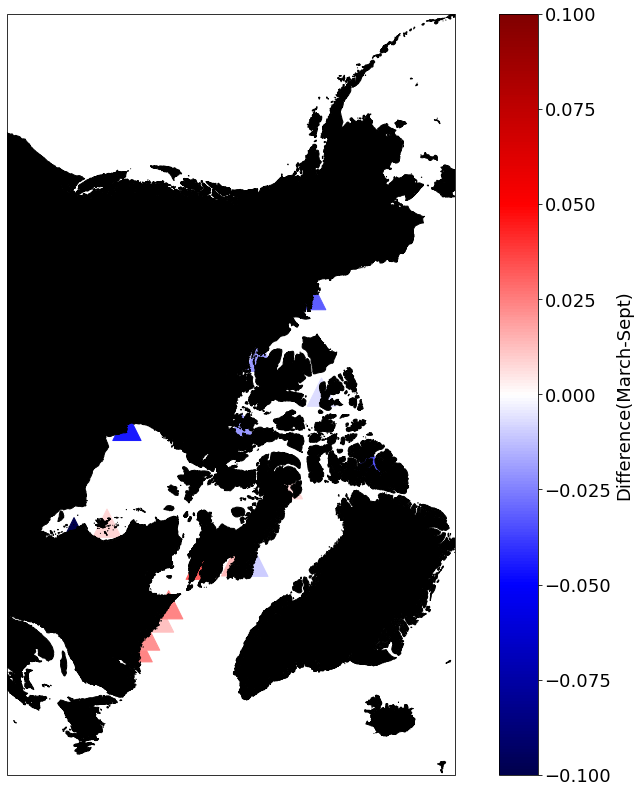

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cpf 
   
# marking the x-axis and y-axis 

fig=plt.figure(figsize=(20, 14), frameon=True)
proj=ccrs.NorthPolarStereo(central_longitude=0.0,true_scale_latitude=None, globe=None)
ax1=fig.add_subplot(1,1,1,projection=proj) 
ax1.set_extent((-158, -47, 49, 84), crs=ccrs.PlateCarree())
# ax.set_extent([-180,180,45,90]) 
cbarlabel='Difference(March-Sept)' 
feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='black',alpha=1)
ax1.add_feature(feature)
# contour_opts = {'levels': np.linspace(0,8,50),
#                 'cmap':'viridis','transform':ccrs.PlateCarree(),'alpha':1}
# cont=ax1.tricontour(triang,scorrval,**contour_opts)
# fig.colorbar(cont)
cont1=ax1.scatter(Lon[index_sig],Lat[index_sig],c=diff[index_sig],transform=ccrs.PlateCarree(),cmap='seismic',marker='^',s=800,vmin=-0.1,vmax=0.1)
cbar=fig.colorbar(cont1,fraction=0.078, pad=0.04)
cbar.set_label(cbarlabel, rotation=90, fontsize=18)
cbar.ax.tick_params(labelsize=18)
plt.show()

Testing FT

In [27]:
j=0
tideconst='M2'
M2ammar=[];M2phmar=[]
M2amsep=[];M2phsep=[]
data={}
for station in tstanamdata[38:39]:
    staname=station[1:-1]
    print(staname)
    a=np.array([i[:-3] for i in os.listdir(datafolder)],dtype='str')
    i=np.where(a==staname)
    print(i)
    stafile=os.path.join(datafolder,os.listdir(datafolder)[i[0][0]])
    stawldata=np.loadtxt(stafile,usecols=(1),dtype='float',skiprows=2)
    statimdata=np.loadtxt(stafile,usecols=(0),dtype='str',skiprows=2)
    stattimtrdata=[datetime.datetime.strptime(i,"%Y-%m-%dT%H:%M:%SZ") for i in statimdata]
    data['time']=stattimtrdata
    data['h']=stawldata
    data['lon']=[tstaposdata[j,0]]
    data['lat']=[tstaposdata[j,1]]

Churchill
(array([711]),)


<ipython-input-23-353e07e42607>:20: RuntimeWarning: divide by zero encountered in true_divide
  timvec=(1/frevec)/3600.


[]
[0.25840413 0.3795415  2.90346965 0.67991594 0.34774207]


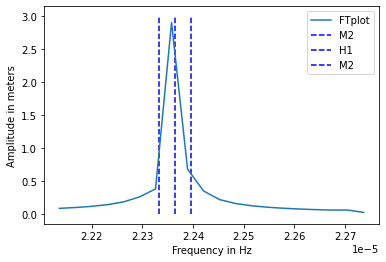

In [23]:
import matplotlib.pyplot as plt
import scipy
sshi=data['h']
meansshi=np.mean(sshi)
mred=sshi-meansshi
# hann = np.hanning(len(mred))
sshft=scipy.fft.fft(mred)
# plt.plot(sshft[:])
# # this shows that the first element is not correct ( don't understand why) but now i do. We should remove the mean beacuse of LLWLT ref.
# sshftN=sshft[1:]
N=int(len(sshft)/2)+1
#plotting abs of amplitude with half the series.
Ampvec=2*np.abs(sshft[:N])/N  #multipy by 2/N
# Ampvec=2*Ampvec  #correction factor for hanning/
dt=int((timedatnum[1]-timedatnum[0])*3600.*24.)
freq=1./dt
# print('dt=%.5fs (Sample Time)' % dt)
# print('freq=%.4fHz (Frequency)' % freq)
frevec=np.linspace(0, freq/2, N, endpoint=True)
timvec=(1/frevec)/3600.
plt.plot(frevec[700:720],Ampvec[700:720],label='FTplot')
tidvec=['M2','H1','H2']
frevec=[0.0000223643,0.0000223326,0.000022396]
plt.vlines(frevec[0],0, 3.0,label='M2',linestyles='--',color='b')
plt.vlines(frevec[1],0, 3.0,label='H1',linestyles='--',color='b')
plt.vlines(frevec[2],0, 3.0,label='M2',linestyles='--',color='b')
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude in meters')
plt.legend()
print(frevec[705:710])
print(Ampvec[705:710])



In [13]:
Nser=len(sshi)
reconstructed_signal = np.zeros(Nser)
reconstructed_signal += sshft[0]*np.ones(Nser)
time_axis = np.linspace(0, Nser-1, Nser)
# Adding the dc term explicitly makes the looping easier in the next step.
num_coefficients=N
for k in range(num_coefficients):
    k += 1  # Bump by one since we already took care of the dc term.
    if k == Nser-k:
        reconstructed_signal += sshft[k] * np.exp(
            1.0j*2*np.pi * (k) * time_axis / Nser)
    # This catches the case where N is even and ensures we don't double-
    # count the frequency k=N/2.

    else:
        reconstructed_signal += sshft[k] * np.exp(
            1.0j*2*np.pi*(k) * time_axis / Nser)
        reconstructed_signal += sshft[Nser-k] * np.exp(
            1.0j*2*np.pi*(Nser-k) * time_axis / Nser)
    # In this case we're just adding a frequency component and it's
    # "partner" at minus the frequency

reconstructed_signal = reconstructed_signal / Nser
# Normalize by the number of points in the signal. numpy's discete Fourier
# transform convention puts the (1/N) normalization factor in the inverse
# transform, so we have to do it here.

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'